<a href="https://colab.research.google.com/github/chernoskutov1989dv/Self-Education/blob/main/stock_price_prediction_program_apple_dmitry_chernoskutov_extended_version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from datetime import timedelta
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from matplotlib import pyplot as plt
from typing import List

In [ ]:
df = pd.read_csv("aapl.us.txt", parse_dates = ["Date"])

In [ ]:
df.shape

(8364, 7)

In [ ]:
df.head(5)

,Date,Open,High,Low,Close,Volume,OpenInt
0,1984-09-07,0.42388,0.42902,0.41874,0.42388,23220030,0
1,1984-09-10,0.42388,0.42516,0.41366,0.42134,18022532,0
2,1984-09-11,0.42516,0.43668,0.42516,0.42902,42498199,0
3,1984-09-12,0.42902,0.43157,0.41618,0.41618,37125801,0
4,1984-09-13,0.43927,0.44052,0.43927,0.43927,57822062,0


In [ ]:
df["Date"].min(), df["Date"].max()

(Timestamp('1984-09-07 00:00:00'), Timestamp('2017-11-10 00:00:00'))

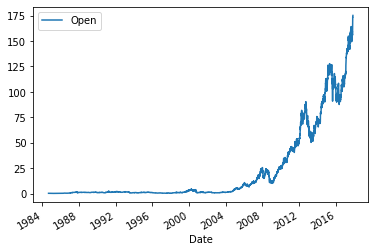

In [ ]:
df.plot(x = "Date", y = "Open")

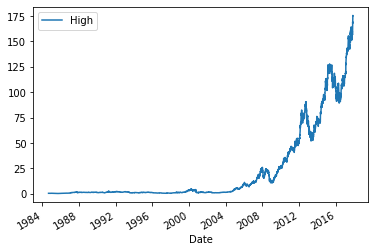

In [ ]:
df.plot(x = "Date", y = "High")

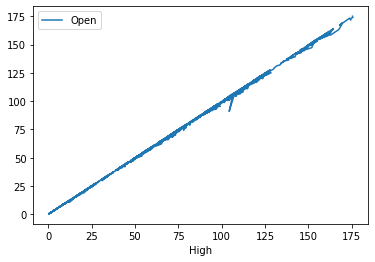

In [ ]:
df.plot(x = "High", y = "Open")

In [ ]:
df[["Open", "Close", "Low", "High"]].corr()

,Open,Close,Low,High
Open,1.000000,0.999902,0.999942,0.999956
Close,0.999902,1.000000,0.999955,0.999953
Low,0.999942,0.999955,1.000000,0.999928
High,0.999956,0.999953,0.999928,1.000000


In [ ]:
df_6_yr = df[df["Date"] > df["Date"].max() - timedelta(days = 365*6)]

In [ ]:
df_6_yr.shape

(1509, 7)

In [ ]:
df_6_yr["Date"].min(), df_6_yr["Date"].max()

(Timestamp('2011-11-14 00:00:00'), Timestamp('2017-11-10 00:00:00'))

In [ ]:
train_size = int (df_6_yr.shape[0]*0.8)
train_df = df_6_yr.iloc [:train_size]
val_df = df_6_yr.iloc [train_size:]

In [ ]:
train_df.shape, val_df.shape

((1207, 7), (302, 7))

In [ ]:
train_df ["Date"].min(), train_df["Date"].max(), val_df ["Date"].min(), val_df["Date"].max()

(Timestamp('2011-11-14 00:00:00'),
 Timestamp('2016-08-31 00:00:00'),
 Timestamp('2016-09-01 00:00:00'),
 Timestamp('2017-11-10 00:00:00'))

In [ ]:
scaler = StandardScaler()
scaler.fit(train_df[["Low"]])

def make_dataset(
    df,
     window_size, 
     batch_size,
     use_scaler=True,
     shuffle=True
     ):
  features = df[["Low"]].iloc[:-window_size]
  if use_scaler:
    features = scaler.transform(features)
  data = np.array(features, dtype=np.float32)
  ds = tf.keras.preprocessing.timeseries_dataset_from_array(
      data=data,
      targets=df["Low"].iloc[window_size:],
      sequence_length=window_size,
      sequence_stride=1,
      shuffle=shuffle,
      batch_size=batch_size)
  return ds

In [ ]:
example_ds = make_dataset(df=train_df, window_size=10, batch_size=2, use_scaler=False, shuffle=False)

In [ ]:
example_feature, example_label = next (example_ds.as_numpy_iterator())

In [ ]:
train_df["Low"].iloc[:6]

6855    48.432
6856    48.592
6857    49.217
6858    48.086
6859    48.009
6860    46.860
Name: Low, dtype: float64

In [ ]:
print (example_feature [0])
print (example_label [0])


[[48.432]
 [48.592]
 [49.217]
 [48.086]
 [48.009]
 [46.86 ]
 [47.503]
 [46.984]
 [46.528]
 [47.426]]
47.409


In [ ]:
print (example_feature [1])
print (example_label [1])

[[48.592]
 [49.217]
 [48.086]
 [48.009]
 [46.86 ]
 [47.503]
 [46.984]
 [46.528]
 [47.426]
 [47.409]]
48.445


In [ ]:
window_size=15
batch_size = 8
train_ds = make_dataset (df = train_df, window_size = window_size, batch_size = batch_size, use_scaler = True, shuffle = True)
val_ds = make_dataset (df=val_df, window_size=window_size, batch_size=batch_size, use_scaler=True, shuffle =True)

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dense(1)
])

In [ ]:
def compile_and_fit(model, train_ds, val_ds, num_epochs: int = 20):
  model.compile(
        loss=tf.losses.MeanSquaredError(),
        optimizer=tf.optimizers.Adam(0.01),
        metrics=[tf.metrics.MeanAbsoluteError()]
      )
  history = model.fit(
      train_ds, 
      epochs=num_epochs,
      validation_data=val_ds,
      verbose=0
      )
  return history

In [ ]:
history =  compile_and_fit(lstm_model, train_ds, val_ds, num_epochs=100)

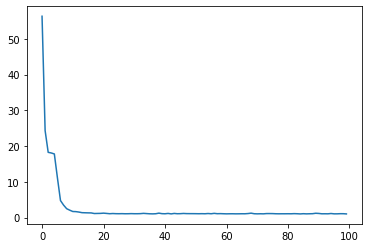

In [ ]:
plt.plot(history.history ["mean_absolute_error"])

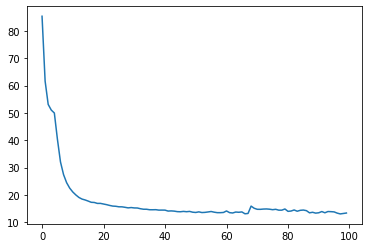

In [ ]:
plt.plot(history.history ["val_mean_absolute_error"])

In [ ]:
lstm_model.evaluate(train_ds)

148/148 [==============================] - 1s 3ms/step - loss: 2.1374 - mean_absolute_error: 1.0359


[2.137418508529663, 1.035904049873352]

In [ ]:
lstm_model.evaluate(val_ds)

35/35 [==============================] - 0s 3ms/step - loss: 290.8665 - mean_absolute_error: 13.4229


[290.86651611328125, 13.422918319702148]

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences = False),
    tf.keras.layers.Dense(1)
])

In [ ]:
history = compile_and_fit (lstm_model, train_ds, val_ds, num_epochs = 500)

In [ ]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 1s 3ms/step - loss: 1.6088 - mean_absolute_error: 0.9224


[1.6088402271270752, 0.9223987460136414]

In [ ]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 3ms/step - loss: 279.7520 - mean_absolute_error: 13.3919


[279.75201416015625, 13.391913414001465]

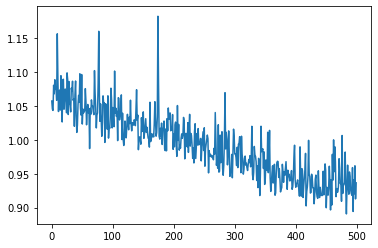

In [ ]:
plt.plot (history.history["mean_absolute_error"])

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(1)
])

In [ ]:
history = compile_and_fit (lstm_model, train_ds, val_ds, num_epochs = 500)

In [ ]:
lstm_model.evaluate(train_ds)

149/149 [==============================] - 1s 3ms/step - loss: 2.4787 - mean_absolute_error: 1.1709


[2.4786648750305176, 1.1709017753601074]

In [ ]:
lstm_model.evaluate(val_ds)

36/36 [==============================] - 0s 3ms/step - loss: 148.2333 - mean_absolute_error: 9.0695


[148.23329162597656, 9.069534301757812]

In [ ]:

plt.plot(history.history["mean_absolute_error"])

In [ ]:
plt.plot(history.history["val_mean_absolute_error"])

In [ ]:
x = np.array ("Date")


In [ ]:
x = np.expand_dims (x, axis = 0)

In [ ]:
#y = model.predict(x)